In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys, os

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import scipy.constants as cst 

import scqubits as scq
import qutip as qt
import qutip.visualization as qplt

from PulseSequence import PulseSequence
from QSwitch import QSwitchTunableTransmonCoupler, QSwitchSNAIL

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

# SNAIL

In [157]:
cutoffs = [5, 5, 5, 5, 5]
# cutoffs = [3]*5

EJs = np.array([15.5, 17, 90]) # GHz
ECs = np.array([0.130, 0.140, 0.170]) # GHz
EL = 60 # GHz
N = 3
beta = 0.2
gs =  1e-3*np.array([5, 300, 300]) # gs=[01, 0c, 1c]


phi_ext = 0.0
qram = QSwitchSNAIL(
    EJs=EJs,
    ECs=ECs,
    EL=EL, beta=beta, N=N,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=True,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], EJ_flux(EJs[-1], phi_ext, dEJ)]/ECs))

bare qubit freqs (GHz) 3.880355935868799 4.218563413717675 6.022181221672648
bare alphas (GHz) -0.1411705092610589 -0.1518999940626351 0
EJ/EC 119.23076923076923 121.42857142857142 529.4117647058823


### Sweep c3, c4

In [109]:
phi_exts = np.linspace(0, 0.5, num=25)
betas = np.linspace(0, 1, num=25)
c3_flux_v_beta = []
c4_flux_v_beta = []

for phi_ext_i in tqdm(phi_exts):
    c3_flux = []
    c4_flux = []
    for beta_i in betas:
        qram = QSwitchSNAIL(
            EJs=EJs,
            ECs=ECs,
            EL=EL, beta=beta_i, N=N,
            gs=gs,
            phi_ext=phi_ext_i,
            is2Q=True,
            cutoffs=cutoffs,
            useZZs=False,
            solve_esys=False,
        )
        c2, c3, c4, c5, p, g3, g4, phi_min = qram.snail_potential_coeff(phi_ext=phi_ext_i)
        c3_flux.append(c3)
        c4_flux.append(c4)
    c3_flux_v_beta.append(c3_flux)
    c4_flux_v_beta.append(c4_flux)
c3_flux_v_beta = np.array(c3_flux_v_beta)
c4_flux_v_beta = np.array(c4_flux_v_beta)

 96%|█████████▌| 24/25 [00:07<00:00,  3.28it/s]RuntimeWarning: invalid value encountered in scalar divide
 s:\Connie\qutip_sims\QSwitch.py: 854RuntimeWarning: invalid value encountered in scalar divide
 s:\Connie\qutip_sims\QSwitch.py: 855RuntimeWarning: invalid value encountered in scalar divide
 s:\Connie\qutip_sims\QSwitch.py: 865RuntimeWarning: invalid value encountered in scalar divide
100%|██████████| 25/25 [00:07<00:00,  3.28it/s]


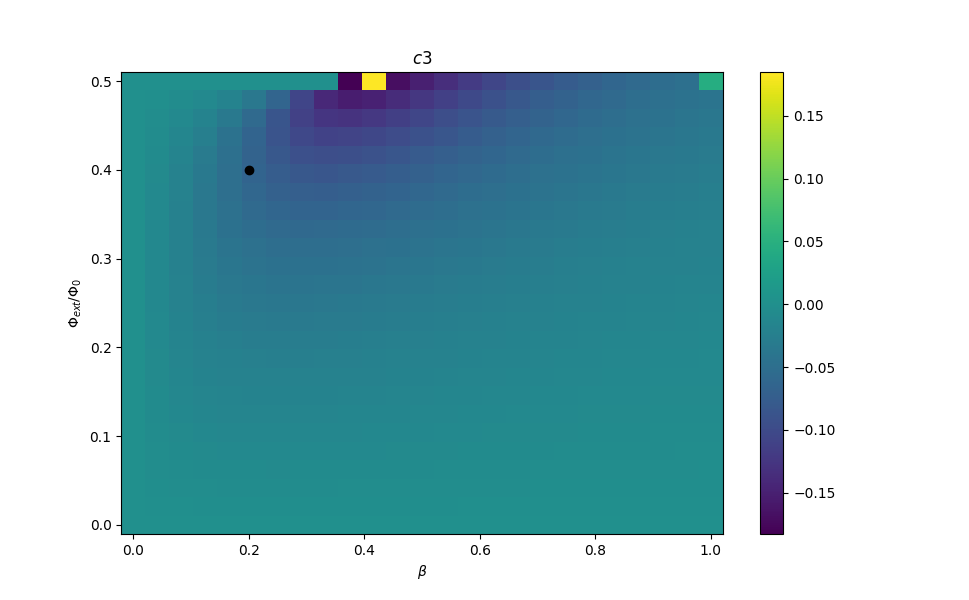

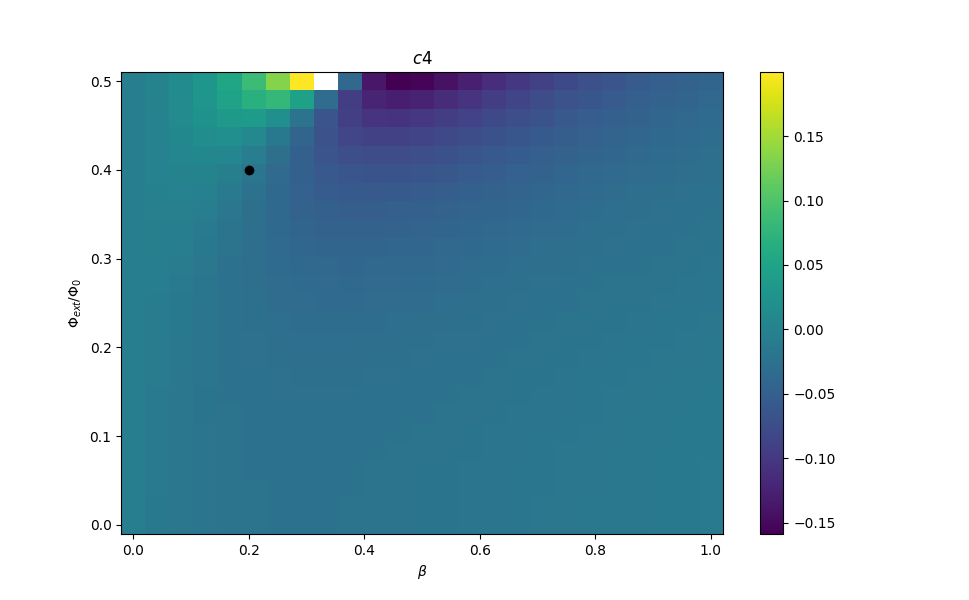

In [112]:
inner_sweep = betas
outer_sweep = phi_exts

y_sweep = outer_sweep
x_sweep = inner_sweep

point = (0.2, 0.4)

plt.figure()
plt.pcolormesh(x_sweep, y_sweep, c3_flux_v_beta, cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.title('$c3$')
plt.ylabel('$\Phi_{ext}/\Phi_0$')
plt.xlabel('$\\beta$')
plt.colorbar()
# plt.clim(-0.01, 0)
plt.show()

plt.figure()
plt.pcolormesh(x_sweep, y_sweep, c4_flux_v_beta, cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.title('$c4$')
plt.ylabel('$\Phi_{ext}/\Phi_0$')
plt.xlabel('$\\beta$')
plt.colorbar()
# plt.clim(-0.001, 0.001)
plt.show()

### Minimize ZZ

In [161]:
phi_exts = np.linspace(0, 0.5, num=200)
ZZ_01_flux = []
evals_flux = []
fc_flux = []
g3_flux = []
g4_flux = []

for phi_ext_i in tqdm(phi_exts):
    qram = QSwitchSNAIL(
        EJs=EJs,
        ECs=ECs,
        EL=EL, beta=beta, N=N,
        gs=gs,
        phi_ext=phi_ext_i,
        is2Q=True,
        cutoffs=cutoffs,
        useZZs=False,
    )
    c2, c3, c4, c5, p, g3, g4, phi_min = qram.snail_potential_coeff(phi_ext=phi_ext_i)
    evals, evecs = qram.esys
    evals_flux.append(evals)
    ZZ_01_flux.append(qram.get_ZZ(0, 1))
    fc_flux = qram.qubit_freqs[-1]
    g3_flux.append(g3)
    g4_flux.append(g4)
ZZ_01_flux = np.array(ZZ_01_flux)
evals_flux = np.array(evals_flux)
fc_flux = np.array(fc_flux)
g3_flux = np.array(g3_flux)
g4_flux = np.array(g4_flux)

100%|██████████| 200/200 [00:15<00:00, 13.04it/s]


Calculate beam splitter rate (charge drive) https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.4.020355

In [162]:
drive_strength = 0.1 # GHz (epsilon in the paper)
f_drive = qram.qubit_freqs[1] + qram.qubit_freqs[1] + qram.alphas[1] - qram.qubit_freqs[0]

g0c = gs[-qram.nqubits + 1]
g1c = gs[-qram.nqubits + 2]
f0 = qram.qubit_freqs[0]
f1 = qram.qubit_freqs[1]

gbs = 6 * g0c/(f0-fc_flux) * g1c/(f1-fc_flux) * drive_strength/(f_drive - fc_flux) * g3_flux

Min ZZ (MHz) 2.076695752252 at phi_ext/phi0 0.45979899497487436
Max ZZ (MHz) 593.2677720787453 at phi_ext/phi0 0.4296482412060302


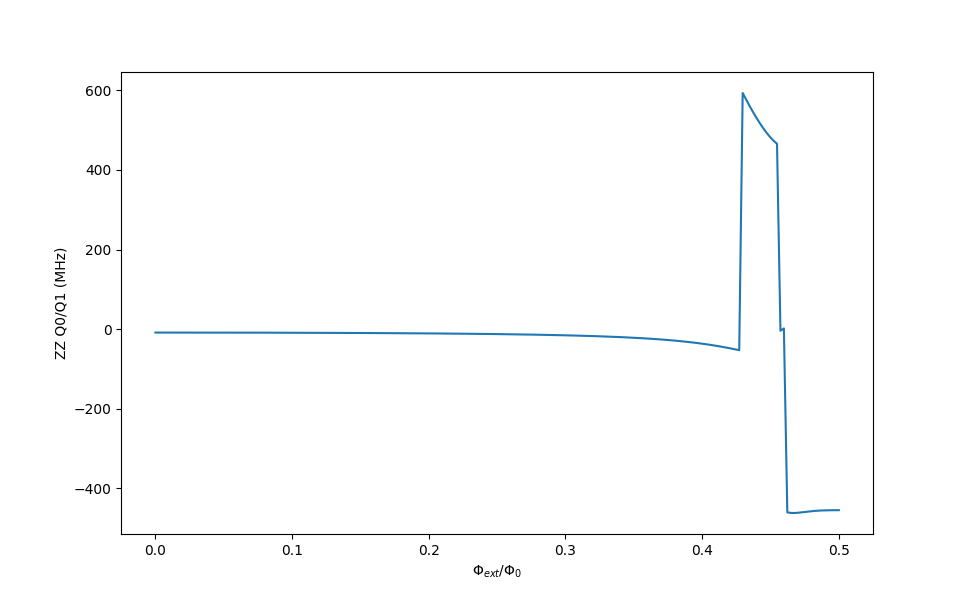

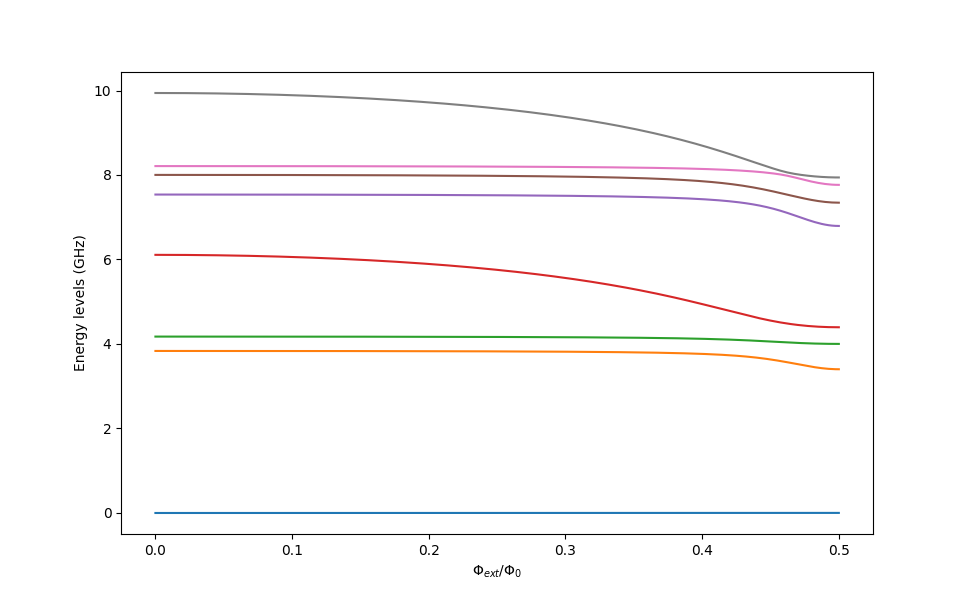

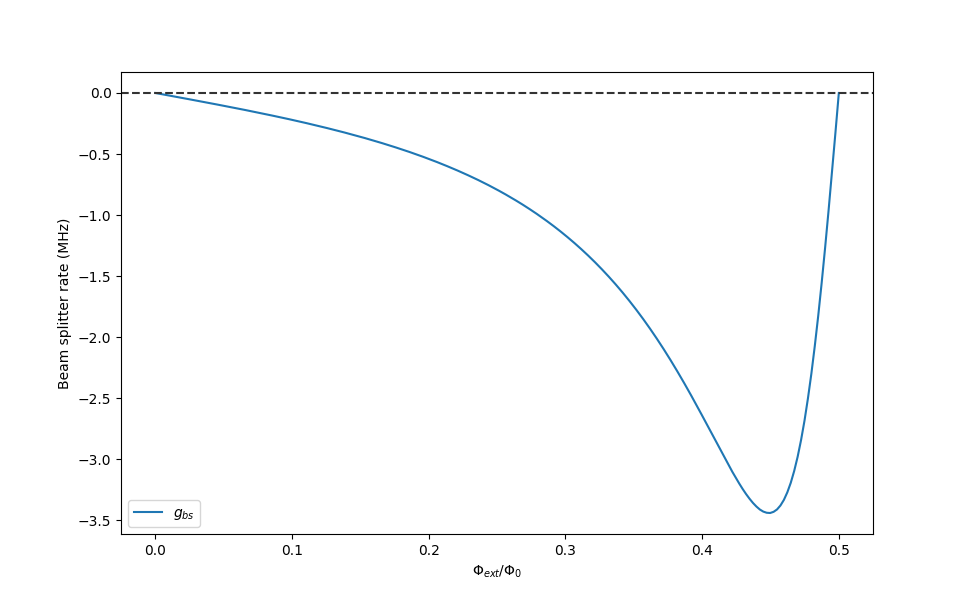

In [163]:
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('Min ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('Max ZZ (MHz)', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, ZZ_01_flux*1e3)
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('ZZ Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 8
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi)
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


plt.figure()
# plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
plt.plot(phi_exts, 1e3*gbs, label='$g_{bs}$')
# plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
plt.axhline(0, linestyle='--', color='0.2')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Beam splitter rate (MHz)')
plt.legend()
plt.show()

Sweep EJ, beta

In [138]:
EJ_snails = np.linspace(50, 150, num=25)
betas = np.linspace(0.1, 0.4, num=25)
phi_exts = [0, 0.5]

ZZ_01_EJvbetavflux = []
evals_EJvbetavflux = []
fc_EJvbetavflux = []
g3_EJvbetavflux = []
g4_EJvbetavflux = []

for EJ in tqdm(EJ_snails):
    ZZ_01_EJvbeta = []
    evals_EJvbeta = []
    fc_EJvbeta = []
    g3_EJvbeta = []
    g4_EJvbeta = []
    for beta_i in betas:
        ZZ_01_EJ = []
        evals_EJ = []
        fc_EJ = []
        g3_EJ = []
        g4_EJ = []
        for phi_ext_i in phi_exts:
            EJ_sweep = [EJs[i] for i in range(qram.nqubits)]
            EJ_sweep[-1] = EJ
            qram = QSwitchSNAIL(
                EJs=EJ_sweep,
                ECs=ECs,
                EL=EL, beta=beta_i, N=N,
                gs=gs,
                phi_ext=phi_ext_i,
                is2Q=True,
                cutoffs=cutoffs,
                useZZs=False,
                solve_esys=True,
            )
            c2, c3, c4, c5, p, g3, g4, phi_min = qram.snail_potential_coeff(phi_ext=phi_ext_i)
            ZZ_01_EJ.append(qram.get_ZZ(0, 1))
            evals, evecs = qram.esys
            evals_EJ.append(evals)
            fc_EJ.append(qram.qubit_freqs[-1])
            g3_EJ.append(g3)
            g4_EJ.append(g4)
        ZZ_01_EJvbeta.append(ZZ_01_EJ)
        evals_EJvbeta.append(evals_EJ)
        fc_EJvbeta.append(fc_EJ)
        g3_EJvbeta.append(g3_EJ)
        g4_EJvbeta.append(g4_EJ)
    ZZ_01_EJvbetavflux.append(ZZ_01_EJvbeta)
    evals_EJvbetavflux.append(evals_EJvbeta)
    fc_EJvbetavflux.append(fc_EJvbeta)
    g3_EJvbetavflux.append(g3_EJvbeta)
    g4_EJvbetavflux.append(g4_EJvbeta)
ZZ_01_EJvbetavflux = np.array(ZZ_01_EJvbetavflux)
evals_EJvbetavflux = np.array(evals_EJvbetavflux)
fc_EJvbetavflux = np.array(fc_EJvbetavflux)
g3_EJvbetavflux = np.array(g3_EJvbetavflux)
g4_EJvbetavflux = np.array(g4_EJvbetavflux)

100%|██████████| 25/25 [01:35<00:00,  3.81s/it]


2 8 -0.012396443455590767


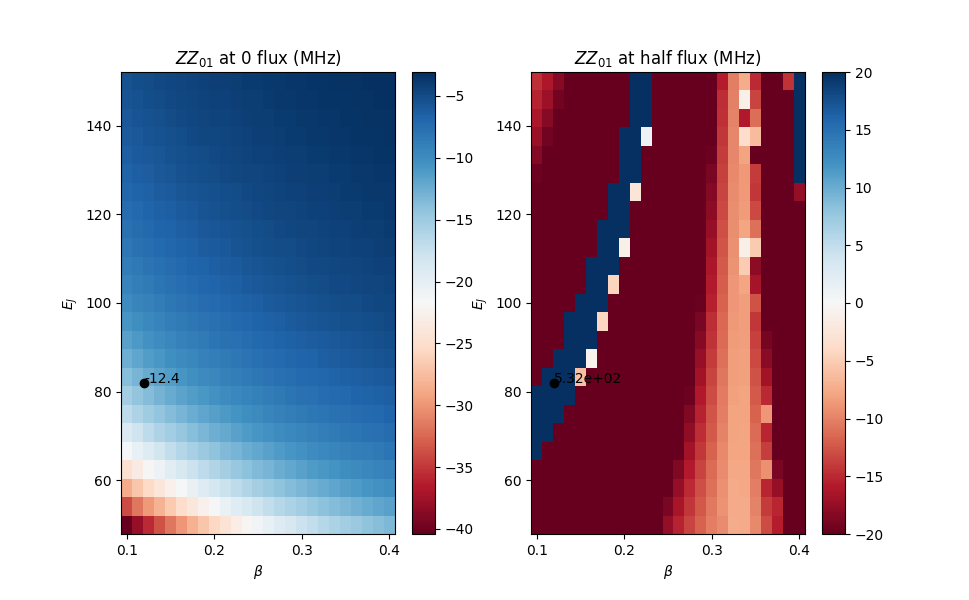

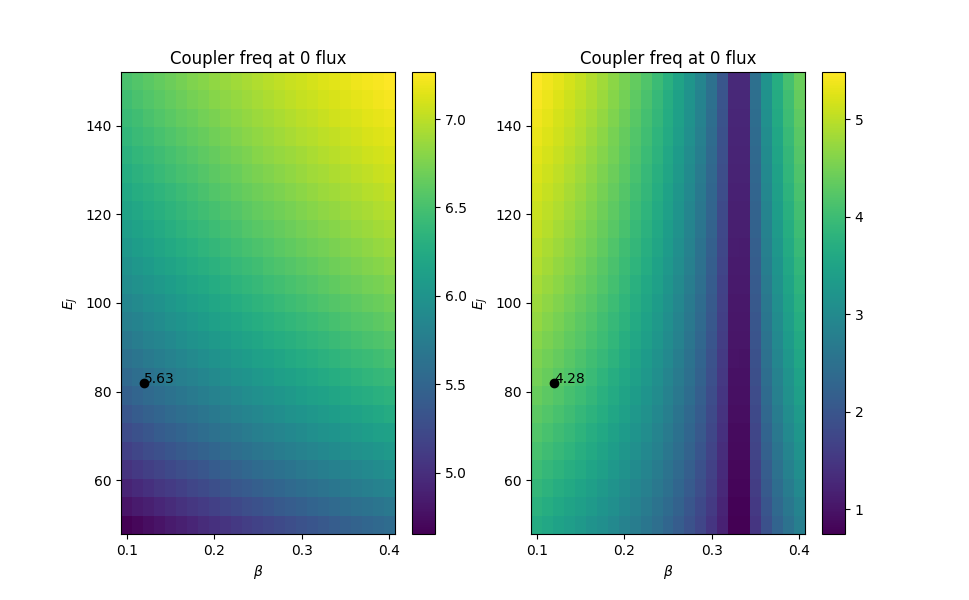

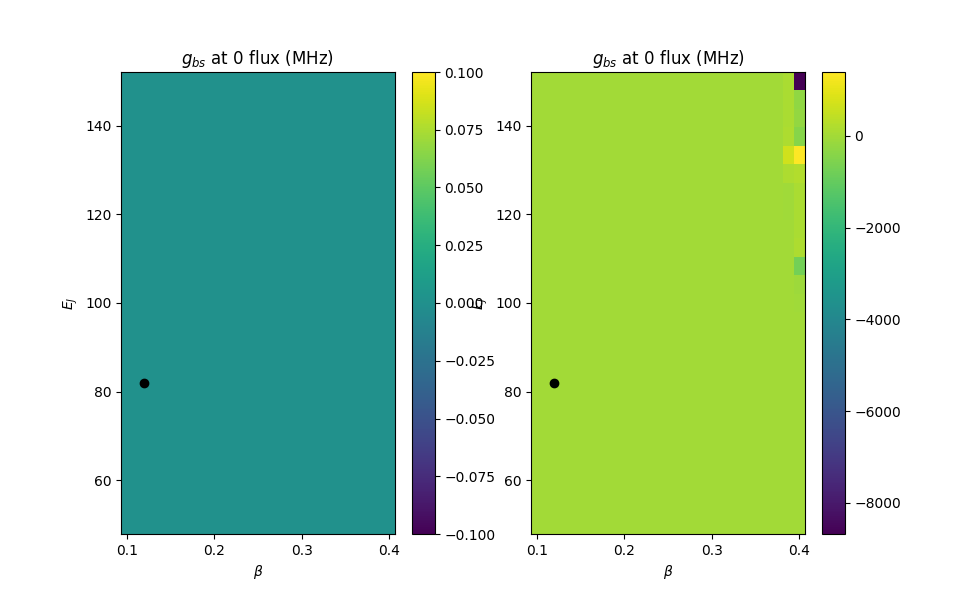

In [156]:
inner_sweep = betas
outer_sweep = EJ_snails

y_sweep = outer_sweep
x_sweep = inner_sweep

point = (0.12, 82)
xloc = np.argmin(np.abs(x_sweep - point[0]))
yloc = np.argmin(np.abs(y_sweep - point[1]))
print(xloc, yloc, ZZ_01_EJvbetavflux[:,:,0][yloc, xloc])

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.pcolormesh(x_sweep, y_sweep, 1e3*ZZ_01_EJvbetavflux[:,:,0], cmap='RdBu', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.annotate(f'{1e3*ZZ_01_EJvbetavflux[:,:,0][yloc, xloc]:.3}', point)
plt.title('$ZZ_{01}$ at 0 flux (MHz)')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
# plt.clim(-0.01, 0)
# ---------- #
plt.sca(ax2)
plt.pcolormesh(x_sweep, y_sweep, 1e3*ZZ_01_EJvbetavflux[:,:,1], cmap='RdBu', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.annotate(f'{1e3*ZZ_01_EJvbetavflux[:,:,1][yloc, xloc]:.3}', point)
plt.title('$ZZ_{01}$ at half flux (MHz)')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
plt.clim([-20, 20])
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.pcolormesh(x_sweep, y_sweep, fc_EJvbetavflux[:,:,0], cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.annotate(f'{fc_EJvbetavflux[:,:,0][yloc, xloc]:.3}', point)
plt.title('Coupler freq at 0 flux')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
# plt.clim(-0.01, 0)
# ---------- #
plt.sca(ax2)
plt.pcolormesh(x_sweep, y_sweep, fc_EJvbetavflux[:,:,1], cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.annotate(f'{fc_EJvbetavflux[:,:,1][yloc, xloc]:.3}', point)
plt.title('Coupler freq at 0 flux')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
plt.show()


drive_strength = 0.1 # GHz (epsilon in the paper)
f_drive = qram.qubit_freqs[1] + qram.qubit_freqs[1] + qram.alphas[1] - qram.qubit_freqs[0]
g0c = gs[-qram.nqubits + 1]
g1c = gs[-qram.nqubits + 2]
f0 = qram.qubit_freqs[0]
f1 = qram.qubit_freqs[1]

gbs = 6 * g0c/(f0 - fc_EJvbetavflux) * g1c/(f1-fc_EJvbetavflux) * drive_strength/(f_drive - fc_EJvbetavflux) * g3_EJvbetavflux

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.pcolormesh(x_sweep, y_sweep, 1e3*gbs[:,:,0], cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.title('$g_{bs}$ at 0 flux (MHz)')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
# plt.clim(-0.01, 0)
# ---------- #
plt.sca(ax2)
plt.pcolormesh(x_sweep, y_sweep, 1e3*gbs[:,:,1], cmap='viridis', shading='auto')
plt.plot(point[0], point[1], marker='o', markeredgecolor='k', markerfacecolor='k')
plt.title('$g_{bs}$ at 0 flux (MHz)')
plt.xlabel('$\\beta$')
plt.ylabel('$E_J$')
plt.colorbar()
plt.show()
